In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 496.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1639
             Open   High    Low  Close   Volume Ticker
Time                                                  
2017-06-02  10590  11040  10510  10950  5519180    SSI
2017-06-05  11000  11040  10740  10740  2811740    SSI
2017-06-06  10800  10910  10720  10870  2952940    SSI
2017-06-07  10950  11140  10930  10980  4110110    SSI
2017-06-08  11040  11210  10930  11060  3599060    SSI
2017-06-09  11120  11300  11080  11140  3427850    SSI


<Axes: xlabel='Time'>

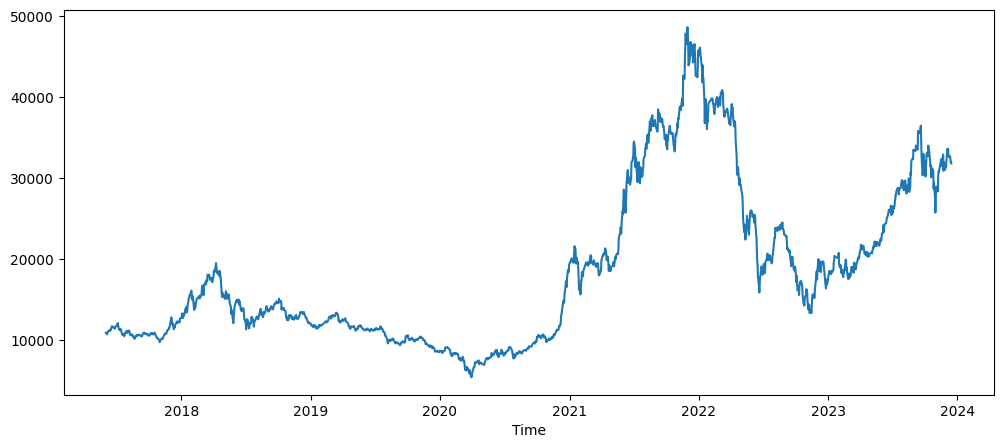

In [3]:
# Import data
SSI = stock_historical_data(symbol = "SSI", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(SSI['Close']))
print(pd.DataFrame(SSI.head(6)))
train_dates = SSI.index
plt.figure(figsize=(12, 5))
SSI["Close"].plot()

In [4]:
SSI = SSI.reset_index(drop = True)
df = SSI['Close']
df

0       10950
1       10740
2       10870
3       10980
4       11060
        ...  
1634    32700
1635    32600
1636    32000
1637    32000
1638    31800
Name: Close, Length: 1639, dtype: int64

In [5]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [6]:
from PyEMD import EMD, CEEMDAN

In [7]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [8]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7
0,65.300826,-27.819280,-550.989658,131.031292,1733.978775,-268.775182,9867.273228
1,-87.050966,-75.658886,-562.624151,128.670004,1736.764712,-268.871257,9868.770545
2,0.780994,-49.501578,-548.233309,126.656614,1738.294732,-268.274695,9870.277242
3,33.153961,-10.343397,-511.272455,125.106166,1738.542093,-266.979634,9871.793267
4,-1.833806,49.441785,-457.521524,124.093036,1737.482501,-264.980655,9873.318663
...,...,...,...,...,...,...,...
1634,73.853195,-447.304026,65.912277,2446.589212,15028.307861,-15176.296799,30708.938280
1635,151.710505,-499.078475,-89.989863,2486.829678,14989.730644,-15145.646152,30706.443663
1636,-146.962356,-676.903545,-210.897451,2491.560395,14953.858644,-15114.565827,30703.910141
1637,129.218127,-860.145761,-263.813804,2455.790120,14920.671521,-15083.057965,30701.337762


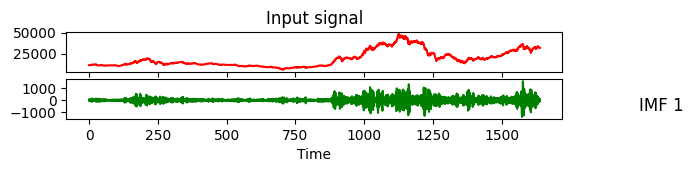

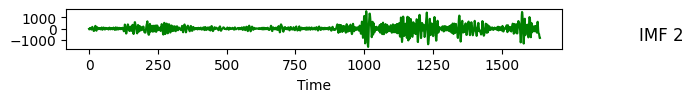

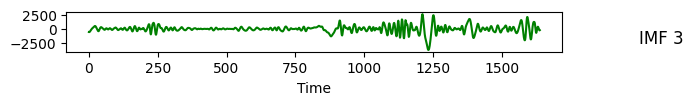

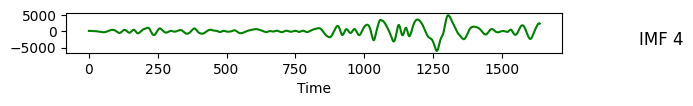

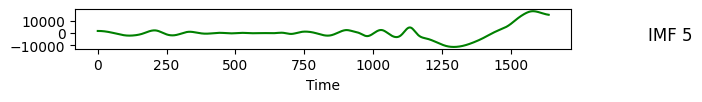

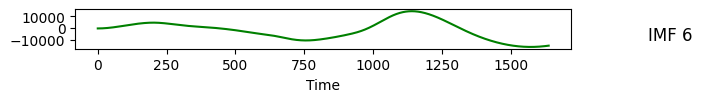

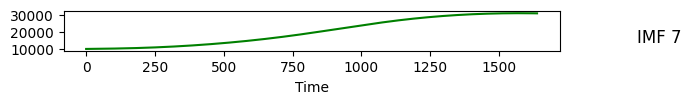

In [9]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [10]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1639, 1)
Residue: (1639, 1)


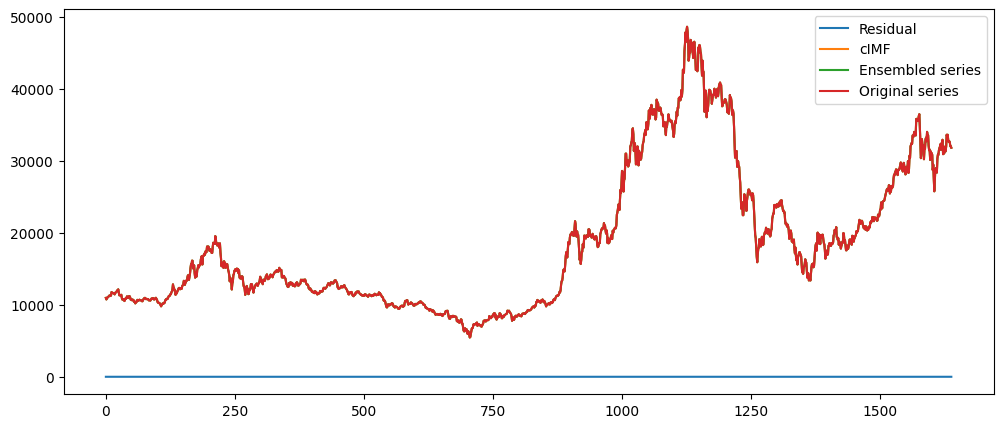

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [12]:
# (B) LSTM
## 0. Prepocessing
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [13]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF

array([[10950.],
       [10740.],
       [10870.],
       ...,
       [32000.],
       [32000.],
       [31800.]])

In [14]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1639, 1)
Train:  (1311, 1)
Test:  (328, 1)


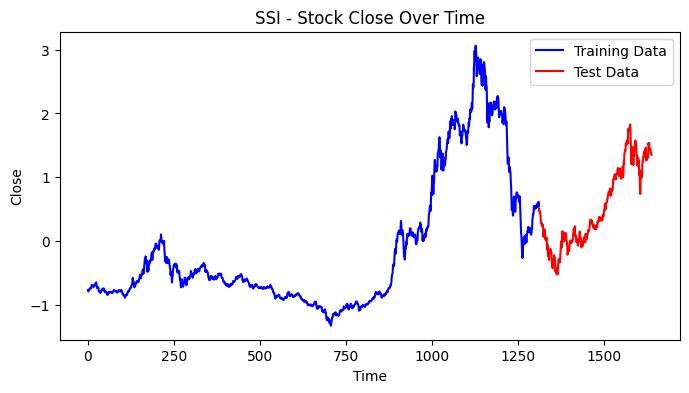

In [16]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.8*IMFscale.shape[0])
test_size = int(0.2*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('SSI - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [18]:
trainX = []
trainY = []

n_past = 60
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (1251, 60, 1)
Y train:  (1251, 1)


In [22]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (268, 60, 1)
Y test:  (268, 1)


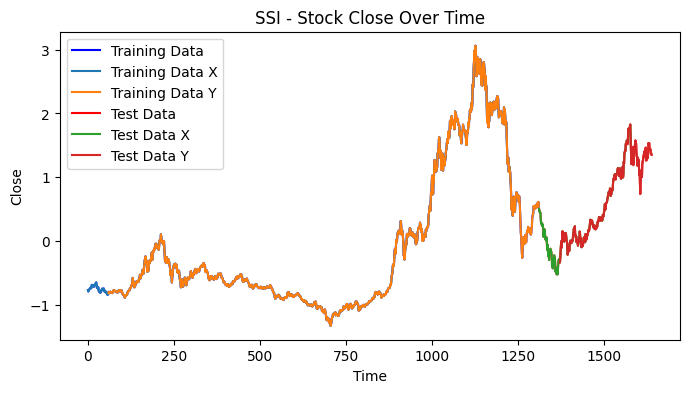

In [23]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('SSI - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [19]:
## 1. Train model
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=4, validation_split=0.1, verbose=1)

Epoch 1/100
282/282 [==============================] - 15s 55ms/step - loss: 25.0090 - val_loss: 48.9571
Epoch 2/100
282/282 [==============================] - 12s 42ms/step - loss: 28.0932 - val_loss: 46.5990
Epoch 3/100
282/282 [==============================] - 12s 43ms/step - loss: 25.4111 - val_loss: 45.3748
Epoch 4/100
282/282 [==============================] - 12s 42ms/step - loss: 30.5715 - val_loss: 58.2777
Epoch 5/100
282/282 [==============================] - 12s 42ms/step - loss: 26.1311 - val_loss: 42.4794
Epoch 6/100
282/282 [==============================] - 12s 42ms/step - loss: 24.1144 - val_loss: 42.2505
Epoch 7/100
282/282 [==============================] - 11s 37ms/step - loss: 23.9241 - val_loss: 44.5672
Epoch 8/100
282/282 [==============================] - 12s 43ms/step - loss: 24.0998 - val_loss: 42.4737
Epoch 9/100
282/282 [==============================] - 12s 42ms/step - loss: 24.8153 - val_loss: 42.0601
Epoch 10/100
282/282 [==============================] -

In [24]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

9/9 [==============================] - 0s 14ms/step
[15789.464  15545.856  15361.6455 15808.992  16645.41   17329.877
 17776.7    18046.752  18225.84   18350.902  18426.549  18471.781
 18503.941  18523.557  18529.88   18535.746  18538.6    18540.32
 18541.88   18543.     18541.498  18536.232  18528.383  18514.59
 18503.275  18496.057  18491.377  18488.1    18485.744  18484.166
 18483.139  18482.418  18481.914  18481.559  18481.312  18481.14
 18481.021  18480.94   18480.88   18480.84   18483.057  18490.055
 18501.521  18512.623  18522.393  18533.38   18537.725  18539.213
 18537.818  18535.922  18529.22   18522.857  18516.139  18508.064
 18499.58   18493.793  18489.797  18487.041  18485.121  18489.352
 18496.107  18498.025  18499.262  18496.592  18491.61   18488.209
 18485.92   18484.322  18483.213  18482.455  18481.936  18481.574
 18481.324  18481.518  18482.652  18482.07   18486.129  18491.447
 18497.707  18500.033  18502.812  18505.691  18509.531  18514.062
 18520.74   18526.736  1853

In [25]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

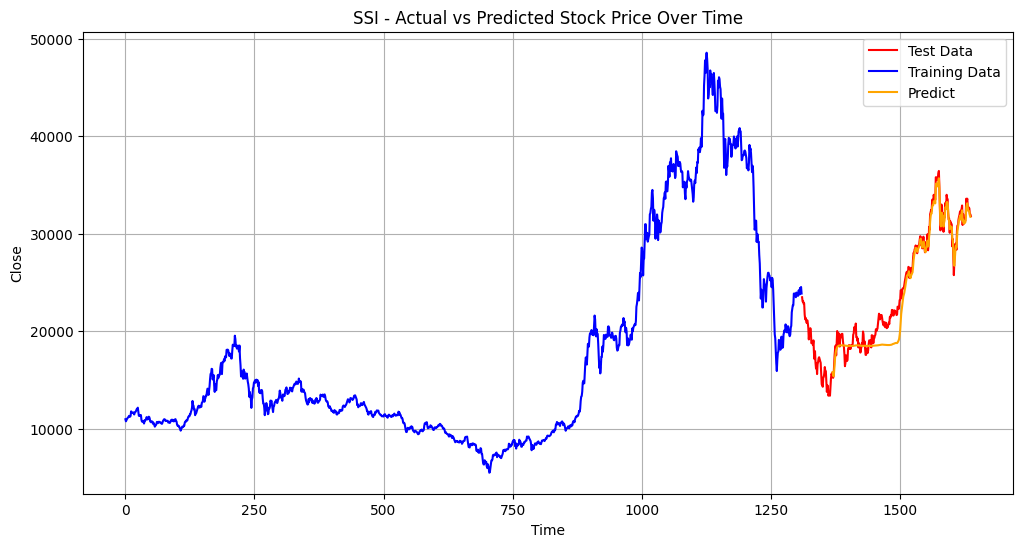

In [26]:
plt.figure(figsize=(12, 6))
n_future = 60

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_future-1, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('SSI - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-60):])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 37ms/step
(329, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 42ms/step
(330, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 38ms/step
(331, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 40ms/step
(332, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 40ms/step
(333, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 40ms/step
(334, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 38ms/step
(335, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 42ms/step
(336, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 52ms/step
(337, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 37ms/step
(338, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 44ms/step
(339, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 38ms/step
(340, 1)
(60, 1)
(1, 60, 1)
1/1 [================

In [28]:
print(y_forecast)

[[31599.316]
 [31428.139]
 [31265.545]
 [31113.406]
 [30970.22 ]
 [30834.762]
 [30706.012]
 [30583.111]
 [30465.334]
 [30352.059]
 [30242.77 ]
 [30137.023]
 [30034.45 ]
 [29934.725]
 [29837.566]
 [29742.725]
 [29649.977]
 [29559.123]
 [29469.969]
 [29382.348]
 [29296.092]
 [29211.045]
 [29127.055]
 [29043.982]
 [28961.68 ]
 [28880.012]
 [28798.84 ]
 [28718.031]
 [28637.447]
 [28556.955]
 [28476.412]
 [28395.68 ]
 [28314.615]
 [28233.068]
 [28150.885]
 [28067.904]
 [27983.955]
 [27898.861]
 [27812.428]
 [27724.455]
 [27634.72 ]
 [27542.984]
 [27448.99 ]
 [27352.453]
 [27253.059]
 [27150.463]
 [27044.281]
 [26934.078]
 [26819.375]
 [26699.621]
 [26574.195]
 [26442.385]
 [26303.371]
 [26156.209]
 [25999.795]
 [25832.836]
 [25653.812]
 [25460.914]
 [25251.975]
 [25024.383]]


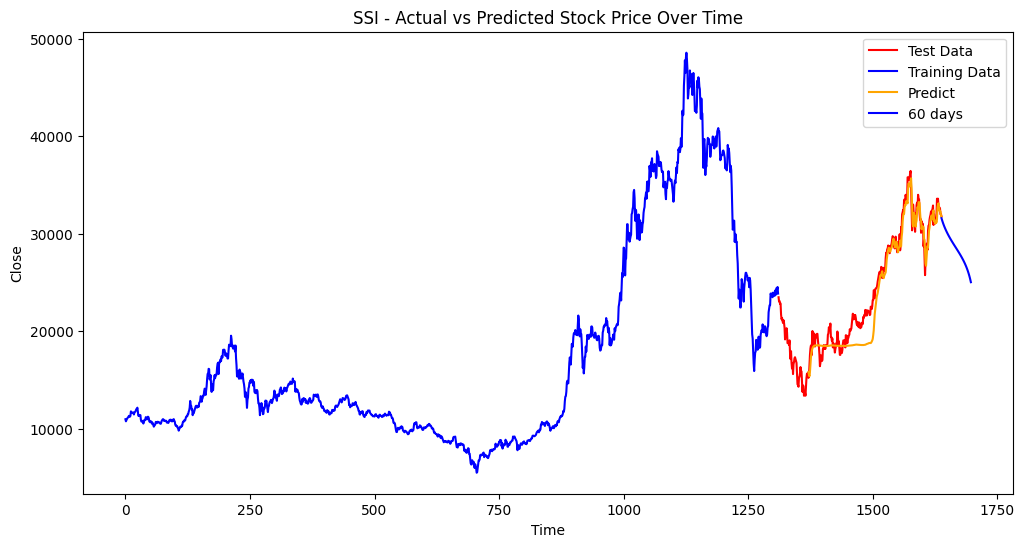

In [29]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size + 60, train_size + test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('SSI - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [30]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100

In [31]:
print("RSME: ", RSME(y_pred_future, test_back[-60:]))
print("MAE: ", MAE(y_pred_future, test_back[-60:]))
print("MAPE: ", MAPE(y_pred_future, test_back[-60:]))

RSME:  9568.208117705948
MAE:  7898.872615438433
MAPE:  25.087796929153722


In [32]:
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("MSLR: ", MSLE(y_pred_future, test_back[14:]))

MSLR:  0.13150867363739033
